# Benchmark Throughput experiment (point to point)
This notebook will show you how to measure the throughput between two Alveo nodes using the benchmark application with UDP as a transport protocol.
We are going to rely on a Dask cluster to configure the local and remote Alveo cards.

This notebook assumes:
* Direct connection between the Alveo cards
* Dask cluster is already created and running. For more information about setting up a Dask cluster visit the [Dask documentation](https://docs.dask.org/en/latest/setup.html)

## Connect to the Dask cluster
1. Connect to the Dask cluster
1. Grab workers name
1. Check if there are two workers available

In [1]:
from dask.distributed import Client, get_client

client = Client("tcp://10.1.212.126:8786")
client

Client Scheduler: tcp://10.1.212.126:8786 Dashboard: http://10.1.212.126:8787/status,Cluster Workers: 2 Cores: 32 Memory: 232.35 GB


In [2]:
client_info = client.scheduler_info()['workers']
workers = []
for cli in client_info:
    workers.append(client_info[cli]['name'])

if len(workers) != 2:
    print("Configure your Dask cluster with two workers")

## Basic remote functions
In this part we are going to schedule a basic function to the workers to verify that we are able to pinpoint tasks to a particular worker, we are also going to grab the Alveo shell name.
You should visually check that your xclbin file is built for the Alveo shell available on the workers.

In [3]:
import platform, os

def verify_workers():
    node_name = platform.node()
    shell_version = os.popen("xbutil dump | grep dsa_name").read()
    #match = True
    #if 'xilinx_u280_xdma_201920_3' not in shell_version:
    #    match = False
    return node_name, shell_version[24:-2]

worker_0 = client.submit(verify_workers ,workers=workers[0], pure=False)
worker_1 = client.submit(verify_workers ,workers=workers[1], pure=False)

worker_check = [worker_0.result(),worker_1.result()]

for w in worker_check:
    print('Worker name: {} | shell version: {}'.format(w[0],w[1]))

Worker name: alveo3b | shell version: "xilinx_u280_xdma_201920_3"
Worker name: alveo3c | shell version: "xilinx_u280_xdma_201920_3"


## Source Dask device and utilities

In this section we will declare the Dask code that builds on top of the `pynq` framework. This piece of code allow us to:

* Download a `xclbin` file to a worker
* Peek and poke registers
* Allocate buffers
* Start kernels

All of these capabilities are available for both local and remote workers

In [1]:
from vnx_utils import *
import pynq
import ctypes
import tempfile
import numpy as np
import re
from pynq.pl_server.xrt_device import XrtStream

# Hold references to buffers to avoid them being collected
# Won't be visible in the process but is an easy way to
# let workers hold on to local references
buffers = []

# Functions that will be called in the context of dask
def _invalidate(bo, offset, size):
    buf = bytearray(size)
    pynq.Device.active_device.invalidate(bo, offset, 0, size)
    pynq.Device.active_device.buffer_read(bo, offset, buf)
    return bytes(buf)

def _flush(bo, offset, size, data):
    pynq.Device.active_device.buffer_write(bo, offset, bytearray(data))
    pynq.Device.active_device.flush(bo, offset, 0, size)
    
def _read_registers(address, length):
    return pynq.Device.active_device.read_registers(address, length)

def _write_registers(address, data):
    pynq.Device.active_device.write_registers(address, data)
    
def _download(bitstream_data):
    with tempfile.NamedTemporaryFile() as f:
        f.write(bitstream_data)
        f.flush()
        ol = pynq.Overlay(f.name)

def _alloc(size, memdesc):
    mem = pynq.Device.active_device.get_memory(memdesc)
    buf = mem.allocate((size,), 'u1')
    buffers.append(buf)
    return buf.bo, buf.device_address

class DaskMemory:
    """Memory object proxied over dask
    
    """
    def __init__(self, device, desc):
        self._desc = desc
        self._device = device
    
    def allocate(self, shape, dtype):
        from pynq.buffer import PynqBuffer
        buf = PynqBuffer(shape, dtype, device_address=0,
                         bo=0, device=self._device, coherent=False)
        bo, addr = self._device._call_dask(_alloc, buf.nbytes, self._desc)
        buf.bo = bo
        buf.device_address = addr
        return buf

class DaskDevice(pynq.Device):
    """PYNQ Proxy device for using PYNQ via dask
    
    """
    def __init__(self, client, worker):
        """The worker ID should be unique
        
        """
        super().__init__("dask-" + re.sub(r'[^\w]', '_', worker))
        self._dask_client = client
        self._worker = worker
        self.capabilities = {
            'REGISTER_RW': True,
            'CALLABLE': True
        }
        self._streams = {}
        
    def _call_dask(self, func, *args):
        future = self._dask_client.submit(func, *args, workers=self._worker, pure=False)
        return future.result()

    def invalidate(self, bo, offset, ptr, size):
        ctype = ctypes.c_uint8 * size
        target = ctype.from_address(ptr)
        target[:] = self._call_dask(_invalidate, bo, offset, size)
        
    def flush(self, bo, offset, ptr, size):
        ctype = ctypes.c_uint8 * size
        target = ctype.from_address(ptr)
        self._call_dask(_flush, bo, offset, size, bytes(target))
        
    def read_registers(self, address, length):
        return self._call_dask(_read_registers, address, length)
    
    def write_registers(self, address, data):
        self._call_dask(_write_registers, address, bytes(data))
        
    def get_bitfile_metadata(self, bitfile_name):
        return pynq.pl_server.xclbin_parser.XclBin(bitfile_name)
    
    def download(self, bitstream, parser=None):
        with open(bitstream.bitfile_name, 'rb') as f:
            bitstream_data = f.read()
        self._call_dask(_download, bitstream_data)
        super().post_download(bitstream, parser)
    
    def get_memory(self, desc):
        if desc['streaming']:
            if desc['idx'] not in self._streams:
                self._streams[desc['idx']] = XrtStream(self, desc)
            return self._streams[desc['idx']]
        else:
            return DaskMemory(self, desc)
    
    def get_memory_by_idx(self, idx):
        for m in self.mem_dict.values():
            if m['idx'] == idx:
                return self.get_memory(m)
        raise RuntimeError("Could not find memory")

## Download xclbin to workers
1. Create Dask device for each worker
2. Create an overlay object for each worker, this step will download the `xclbin` file to the Alveo card

In [5]:
# daskdev_w0 = DaskDevice(client, workers[0])
# daskdev_w1 = DaskDevice(client, workers[1])

devices = pynq.Device.devices

xclbin = '../benchmark.intf3.xilinx_u280_xdma_201920_3/vnx_benchmark_if3.xclbin'
xclbin = '../benchmark.intf1.xilinx_u280_xdma_201920_3/vnx_benchmark_if1.xclbin'
xclbin_sketch = "/home/aliu/xclbins/count-sketch-emem/benchmark.intf1.sketch1_cs_r3_c10_e10_h4.xilinx_u280_xdma_201920_3/vnx_benchmark_if1.xclbin"
xclbin_sketch = "/home/aliu/xclbins/univmon-le/benchmark.intf1.sketch1_univmon_l16_le16_r3_c8_e8_h2.xilinx_u280_xdma_201920_3/vnx_benchmark_if1.xclbin"
ol_w0 = pynq.Overlay(xclbin_sketch, device=devices[0])
ol_w1 = pynq.Overlay(xclbin_sketch, device=devices[1])

## Check Link 

We are going to use the function `linkStatus` that reports if the CMAC is detecting link, which means that the physical connection
between the two Alveo cards is established.

In [6]:
print("Link worker 0 {}; link worker 1 {}".format(ol_w0.cmac_1.linkStatus(),ol_w1.cmac_1.linkStatus()))

Link worker 0 {'cmac_link': True}; link worker 1 {'cmac_link': True}


### Configure remote Alveo card

1. Set up IP address and MAC address
2. Set up connection table
3. Launch ARP discovery
4. Print out ARP Table 

In [7]:
print(ol_w1.networklayer_1.updateIPAddress('192.168.0.10', debug=True))
#2
ol_w1.networklayer_1.sockets[1] = ('192.168.0.5', 62177, 60512, True)
ol_w1.networklayer_1.populateSocketTable()
#3 
ol_w1.networklayer_1.arpDiscovery()
#4
ol_w1.networklayer_1.readARPTable()

{'HWaddr': '00:0a:35:02:9d:0a', 'inet addr': '192.168.0.10', 'gateway addr': '192.168.0.1', 'Mask': '255.255.255.0'}
Position   5	MAC address 00:0a:35:02:9d:e5	IP address 192.168.0.5


### Configure local Alveo card

1. Print out IP and MAC address
2. Set up connection table
3. Launch ARP discovery
4. Print out ARP Table 

In [8]:
print(ol_w0.networklayer_1.getNetworkInfo())
#2
ol_w0.networklayer_1.sockets[7] = ('192.168.0.10', 60512, 62177, True)
ol_w0.networklayer_1.populateSocketTable()
#3 
ol_w0.networklayer_1.arpDiscovery()
#4
ol_w0.networklayer_1.readARPTable()

{'HWaddr': '00:0a:35:02:9d:e5', 'inet addr': '192.168.0.5', 'gateway addr': '192.168.0.1', 'Mask': '255.255.255.0'}
Position  10	MAC address 00:0a:35:02:9d:0a	IP address 192.168.0.10


## Configure application
* Configure remote traffic generator 1 in `CONSUMER` mode

In [9]:
ol_w1_tg = ol_w1.traffic_generator_1_1
ol_w1_tg.register_map.debug_reset = 1
ol_w1_tg.register_map.mode = benchmark_mode.index('CONSUMER')
ol_w1_tg.register_map.CTRL.AP_START = 1

In [19]:
import yaml
num_packets = 1000_000

In [20]:
manifests_file_path = "../tools/manifests/ground_truth_univmon-emem.yml"
with open(manifests_file_path) as f:
    manifests = yaml.safe_load(f)

In [21]:
sketch_manifest = manifests[0]['sketches'][0]
sketch_manifest

{'frac': 1,
 'hash_units': 2,
 'logcols': 8,
 'logcols_emem': 8,
 'rows': 3,
 'sketch_name': 'UNIVMON',
 'thr': 1,
 'univmon_levels': 16,
 'univmon_levels_emem': 16}

In [22]:
# Checking if using gmem
using_gmem = False
sketch_buf = None
sketch_wh = None
if('logcols_emem' in sketch_manifest):
    using_gmem = True
    print("Setting up memory buffers")
    sketch_kernel = ol_w0.update_sketch_1
    r = int(sketch_manifest['rows'])
    lce = int(sketch_manifest['logcols_emem'])
    ce = (1<<lce)
    size = r * ce
    shape = (r, ce)
    if(sketch_manifest['sketch_name'] == 'UNIVMON'):
        le = int(sketch_manifest['univmon_levels_emem'])
        lc = int(sketch_manifest['logcols'])
        assert(lc == lce)
        size = r * le * ce
        shape = (r, le, ce)
    sketch_buf = pynq.allocate(shape, dtype=np.uint32, target=ol_w0.HBM1)
    sketch_wh = sketch_kernel.start(sketch_buf, num_packets)

Setting up memory buffers


In [24]:
sketch_buf.sync_from_device()

In [27]:
sketch_buf.sync_to_device()

In [ ]:
import numpy as np

In [31]:
np.count_nonzero(sketch_buf)

50

In [32]:
np.sum(sketch_buf)

PynqBuffer(98784247813, dtype=uint64)

* Configure local traffic generator 1
* Run the application for different packet sizes
* Compute and store results for both local (Tx) and remote (Rx)

In [39]:
buf_arr = np.array(sketch_buf)
buf_arr[buf_arr != 0].astype('int32')

array([ 1,  1,  1, -1,  1, -1, -1, -1,  1, -1,  1,  1, -1,  1,  1, -1,  1,
       -1, -1, -1,  1,  1, -1, -1, -1, -1,  1, -1,  1, -1,  1, -1, -1,  1,
       -1,  1, -1, -1,  1,  1,  1,  1,  1,  2,  1,  1, -1,  1, -1,  1],
      dtype=int32)

In [23]:
import time
freq = 292
ol_w0_tg = ol_w0.traffic_generator_1_3
experiment_dict = {}
local_dict = {}
ol_w0_tg.register_map.mode = benchmark_mode.index('PRODUCER')
ol_w0_tg.register_map.dest_id = 7
ol_w1_tg.freq = freq
ol_w0_tg.freq = freq
# for pkt in [1000000, 1000000000]:
for pkt in [num_packets]:
    ol_w0_tg.register_map.debug_reset = 1
    ol_w1_tg.register_map.debug_reset = 1
    ol_w0_tg.register_map.time_between_packets = 0
    ol_w0_tg.register_map.number_packets = pkt
    local_dict = {}
    # for i in range(23):
    for i in range(1):
        beats = i + 1
        ol_w0_tg.register_map.number_beats = beats
        ol_w0_tg.register_map.CTRL.AP_START = 1
        while int(ol_w0_tg.register_map.out_traffic_packets) != pkt:
            print("Packets sent till now: ", int(ol_w0_tg.register_map.out_traffic_packets))
            time.sleep(0.8)
        # Get results from local and remote worker
        rx_tot_pkt, rx_thr, rx_time = ol_w1_tg.computeThroughputApp('rx')
        tx_tot_pkt, tx_thr, tx_time = ol_w0_tg.computeThroughputApp('tx')
        #Create dict entry for this particular experiment
        entry_dict = {'size': (beats * 64), 'rx_pkts' : rx_tot_pkt, 'tx_thr': tx_thr, 'rx_thr': rx_thr}
        local_dict[beats] = entry_dict
        # Reset probes to prepare for next computation
        ol_w0_tg.resetProbes()
        ol_w1_tg.resetProbes() 
        print("Sent {:14,} size: {:4}-Byte done!\tGot {:14,} took {:8.4f} sec, thr: {:.3f} Gbps"\
              .format(pkt,beats*64, rx_tot_pkt, rx_time, rx_thr))
        time.sleep(0.5)
    experiment_dict[pkt] = local_dict

Packets sent till now:  799
Sent      1,000,000 size:   64-Byte done!	Got      1,000,000 took   0.0771 sec, thr: 6.645 Gbps


## Plot the results
Finally we can plot the results using matplotlib.

Note that the throughput is around 3 % bigger than the theoretical, this is because the CMAC uses 4 lanes of 25.78125G each and in point to point there is no limiting equipment

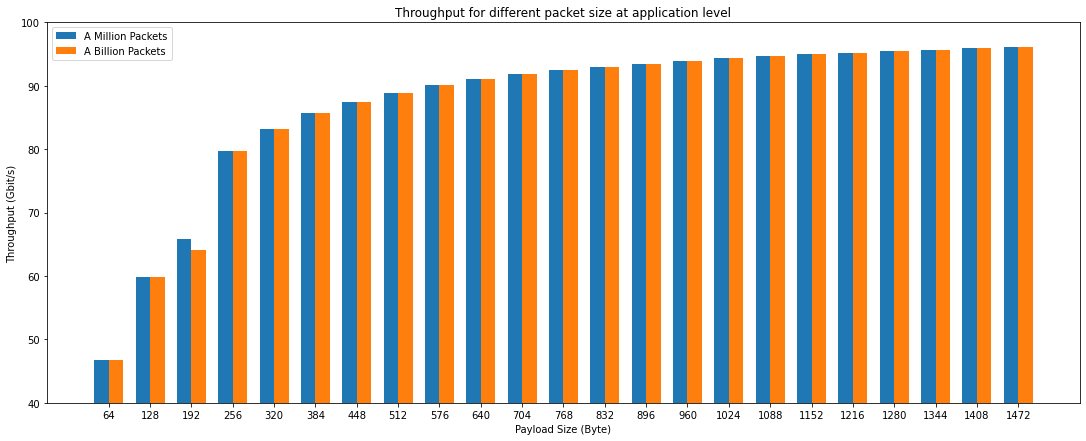

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

dict_oneM = experiment_dict[1000000]
dict_oneB = experiment_dict[1000000000]
labels = []
oneM_thr = []
oneB_thr = []

for b in dict_oneM:
    labels.append(dict_oneM[b]['size'])
    oneM_thr.append(dict_oneM[b]['rx_thr'])

for b in dict_oneB:
    oneB_thr.append(dict_oneB[b]['rx_thr'])

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, oneM_thr, width, label='A Million Packets')
rects2 = ax.bar(x + width/2, oneB_thr, width, label='A Billion Packets')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Throughput (Gbit/s)')
ax.set_xlabel('Payload Size (Byte)')
ax.set_title('Throughput for different packet size at application level')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.set_ylim(40,100)
fig.set_size_inches(18.5, 7)
plt.show()

## Release Alveo cards
To release the alveo cards the pynq overlay is freed

In [25]:
pynq.Overlay.free(ol_w0)
pynq.Overlay.free(ol_w1)

------------------------------------------
Copyright (c) 2020-2021, Xilinx, Inc.